# Building a Throw-In Classifier Using Transfer Learning
Trying to identify clips of throw-ins from Bundesliga games. This transfer learning model will be built with fastai and this notebook will build and train that model.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v3 as iio 
import cv2
import os

from fastai.data.all import *
from fastai.vision.all import *

from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
from IPython.display import Video
from tqdm.notebook import tqdm

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
data_path = Path('data/')
train_df = pd.read_csv(data_path/'train.csv')
train_df.head()

,video_id,time,event,event_attributes
0,1606b0e6_0,200.265822,start,NaN
1,1606b0e6_0,201.150000,challenge,['ball_action_forced']
2,1606b0e6_0,202.765822,end,NaN
3,1606b0e6_0,210.124111,start,NaN
4,1606b0e6_0,210.870000,challenge,['opponent_dispossessed']


In [3]:
df_throwin = train_df[train_df['event'] == 'throwin'].copy()

In [4]:
def vis_event(row, before=5, after=5):
    print(row["event_attributes"])
    filename = f"train_{row.name}.mp4"
    ffmpeg_extract_subclip(
        f'data/train/{row["video_id"]}.mp4',
        #f"../input/dfl-bundesliga-data-shootout/train/{row['video_id']}.mp4", 
        row['time'] - before, 
        row['time'] + after, 
        targetname=filename
    )
    
    return Video(filename, width=800)

In [5]:
r = df_throwin.iloc[0]
vis_event(r,0.35,0.35)

['pass']
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


In [6]:
def get_image(vid_id, frame, ind):
    video_file = data_path/'train'/vid_id
    p = data_path/vid_id/ind
    if not os.path.exists(p):
        os.makedirs(p)
    if not os.path.exists(p/f'/{frame}.png'):
        image = iio.imread(f'{video_file}.mp4', index=frame)
        iio.imwrite(p/f'{frame}.png', image)

In [7]:
# fps = 25
# fnames = []
# for i, row in tqdm(df_throwin.iterrows(), total=len(df_throwin)):
#     vid_id = row['video_id']
#     t1 = row['time'] - 0.15
#     t2 = row['time'] + 0.15
#     frame_start = int(t1 * fps)
#     frame_end = int(t2 * fps)

#     video_file = data_path/'train'/vid_id
#     p = data_path/vid_id/f'{i}'
#     if not os.path.exists(p):
#         os.makedirs(p)
#     for j in range(frame_start, frame_end + 1):
#         if not os.path.exists(p/f'/{j}.png'):
#             image = iio.imread(f'{video_file}.mp4', index=j)
#             iio.imwrite(p/f'{j}.png', image)
#     fnames.append(p)
#     #try:
#     #    fps = train_meta[vid_id]
#     #except KeyError:
#     #    video = cv2.VideoCapture(f'{video_file}.mp4')
#     #    fps = video.get(cv2.CAP_PROP_FPS)
#     #    train_meta[vid_id] = fps
# df_throwin['fname'] = fnames

In [8]:
fps = 25
def get_images(vid_id, time, ind):
    t1 = time - 0.15
    t2 = time + 0.15
    frame_start = int(t1 * fps)
    frame_end = int(t2 * fps)

    video_file = data_path/'train'/vid_id
    p = data_path/vid_id/f'{ind}'
    if not os.path.exists(p):
        os.makedirs(p)
    for j in range(frame_start, frame_end + 1):
        if not os.path.exists(p/f'{j}.png'):
            try:
                image = iio.imread(f'{video_file}.mp4', index=j)
                iio.imwrite(p/f'{j}.png', image)
            except IndexError:
                print(j, p)
                p = None
    return p

In [9]:
fnames = [get_images(v, t, i) for v, t, i in tqdm(zip(df_throwin['video_id'], df_throwin['time'], df_throwin.index.values), total=len(df_throwin))]
df_throwin['fnames'] = fnames
fnames[0:3]

  0%|          | 0/172 [00:00<?, ?it/s]

[Path('data/1606b0e6_0/7'),
 Path('data/1606b0e6_0/101'),
 Path('data/1606b0e6_0/119')]

In [10]:
# making a negative dataset the size of the positive one
scale = 1

pos_set = df_throwin['time'].astype(int)
neg_set = []
while len(neg_set) < len(df_throwin) * scale:
    tmp = random.randint(1,(12*60)-1)
    if tmp not in neg_set and tmp not in pos_set:
        neg_set.append(tmp)

neg_paths = []
for a in data_path.ls():
    if '.' not in str(a):
        for b in a.ls():
            if '-' in str(b):
                neg_paths.append(b)
if len(neg_paths) < len(neg_set):
    vid_paths = data_path/'train'
    vid_paths = vid_paths.ls()
    index = -1*len(neg_set)
    for t in tqdm(neg_set):
        i = random.randint(0,len(vid_paths)-1)
        neg_paths.append(get_images(vid_paths[i].stem, t, index))
        index += -1
elif len(neg_paths) > len(neg_set):
    tmp = []
    for i in range(-1,(len(neg_set)+1)*-1,-1):
        for a in data_path.ls():
            if '.' not in str(a):
                for b in a.ls():
                    if str(i) == str(b.stem):
                        tmp.append(b)
    del neg_paths
    neg_paths = tmp
    print(len(neg_paths))

176


In [11]:
neg_paths[:3]

[Path('data/ecf251d4_0/-1'),
 Path('data/4ffd5986_0/-2'),
 Path('data/1606b0e6_0/-3')]

In [12]:
df_train = pd.DataFrame(df_throwin.fnames.copy())
df_train['label'] = ['throwin'] * len(df_throwin)
len(df_train)
df_neg = pd.DataFrame({'fnames': neg_paths, 'label': ['no_throwin'] * len(neg_paths)})
df_train = pd.concat([df_train, df_neg])

In [13]:
p = data_path/'train'
p.ls()[0].stem

'1606b0e6_0'

In [14]:
class ImageTuple(fastuple):
    "A tuple of PILImages"
    def show(self, ctx=None, **kwargs): 
        n = len(self)
        img0, img1, img2= self[0], self[n//2], self[n-1]
        if not isinstance(img1, Tensor):
            t0, t1,t2 = tensor(img0), tensor(img1),tensor(img2)
            t0, t1,t2 = t0.permute(2,0,1), t1.permute(2,0,1),t2.permute(2,0,1)
        else: t0, t1,t2 = img0, img1,img2
        return show_image(torch.cat([t0,t1,t2], dim=2), ctx=ctx, **kwargs)

In [15]:
class ImageTupleTfm(Transform):
    "A wrapper to hold the data on path format"
    def __init__(self, seq_len=20):
        store_attr()
        
    def encodes(self, path: Path):
        "Get a list of images files for folder path"
        frames = path.ls_sorted()
        n_frames = len(frames)
        s = slice(0, min(self.seq_len, n_frames))
        return ImageTuple(tuple(PILImage.create(f) for f in frames[s]))

In [16]:
@patch
def ls_sorted(self:Path):
    "ls but sorts files by name numerically"
    try:
        return self.ls().sorted(key=lambda f: int(f.with_suffix('').name))
    except ValueError:
        return self.ls().sorted(key=lambda f: int(f.with_suffix('').name.split('-')[1]))

In [17]:
def labeller(path):
    return '-' not in str(path)

In [18]:
instances_path = df_train.fnames.copy()
splits = RandomSplitter()(instances_path)

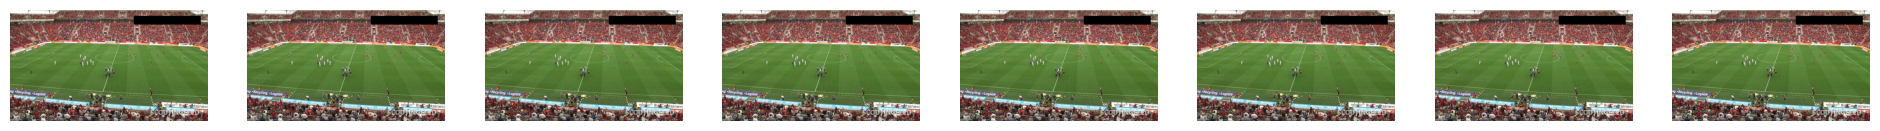

In [19]:
frames = instances_path[0].ls_sorted()
show_images([Image.open(img) for img in frames])

In [20]:
ds = Datasets(instances_path, tfms=[[ImageTupleTfm(8)], [labeller, Categorize()]], splits=splits)

In [21]:
len(ds)

348

In [22]:
def get_action_dataloaders(files, bs=8, image_size=64, seq_len=20, val_idxs=None, **kwargs):
    "Create a dataloader with `val_idxs` splits"
    splits = RandomSplitter()(files) if val_idxs is None else IndexSplitter(val_idxs)(files)
    itfm = ImageTupleTfm(seq_len=seq_len)
    ds = Datasets(files, tfms=[[itfm], [labeller, Categorize()]], splits=splits)
    dls = ds.dataloaders(bs=bs, after_item=[Resize(image_size), ToTensor], 
                         after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)], drop_last=True, **kwargs)
    return dls

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


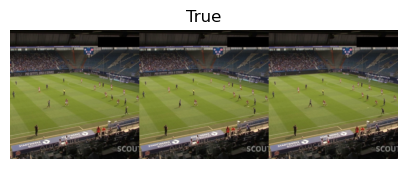

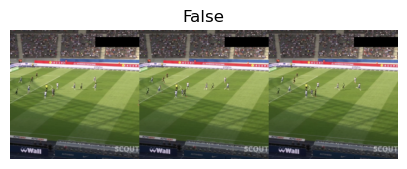

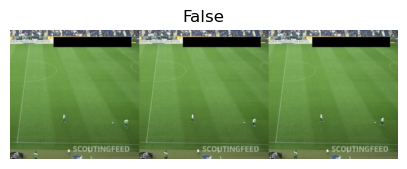

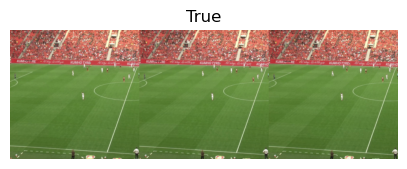

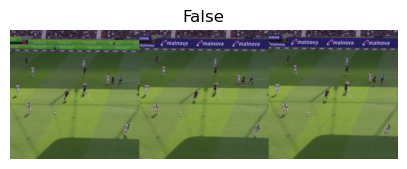

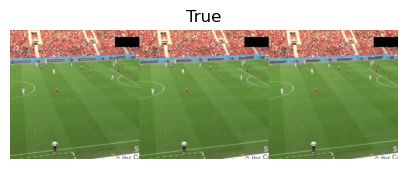

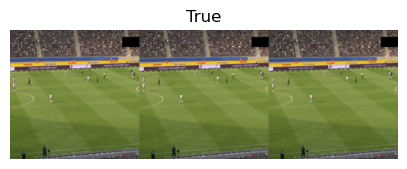

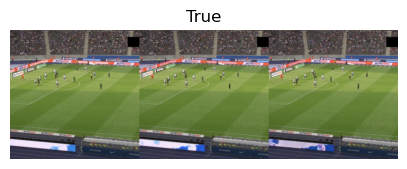

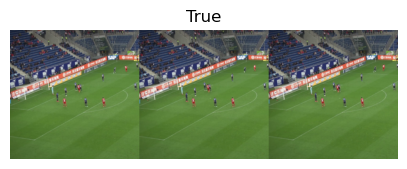

In [23]:
dls = get_action_dataloaders(instances_path, bs=16, image_size=256, seq_len=8)
dls.show_batch()

In [37]:
arch = resnet34()
encoder = nn.Sequential(create_body(arch, pretrained=True), nn.AdaptiveAvgPool2d(1), Flatten()).cuda()

In [25]:
x,y = dls.one_batch()

In [33]:
y

TensorCategory([1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0],
               device='cuda:0')

In [38]:
print(f'{type(x) = },\n{len(x) = } ,\n{x[0].shape = }, \n{encoder(x[0]).shape = }')

type(x) = <class '__main__.ImageTuple'>,
len(x) = 8 ,
x[0].shape = torch.Size([16, 3, 256, 256]), 
encoder(x[0]).shape = torch.Size([16, 512])


In [27]:
tencoder = TimeDistributed(encoder)
tencoder(torch.stack(x, dim=1)).shape

torch.Size([16, 8, 512])

In [28]:
class RNNModel(Module):
    def __init__(self, arch=resnet34(), n_out=101, num_rnn_layers=1):
        self.encoder = TimeDistributed(nn.Sequential(create_body(arch, pretrained=True), nn.AdaptiveAvgPool2d(1), Flatten()))
        self.rnn = nn.LSTM(512, 512, num_layers=num_rnn_layers, batch_first=True)
        self.head = LinBnDrop(num_rnn_layers*512, n_out)
    def forward(self, x):
        x = torch.stack(x, dim=1)
        x = self.encoder(x)
        bs = x.shape[0]
        _, (h, _) = self.rnn(x)
        return self.head(h.view(bs,-1))

In [29]:
def rnnmodel_splitter(model):
    return [params(model.encoder), params(model.rnn)+params(model.head)]

In [30]:
model = RNNModel().cuda()

In [40]:
learn = Learner(dls, model, metrics=[error_rate, F1Score(average='micro')], splitter=rnnmodel_splitter).to_fp16()

SuggestedLRs(valley=0.0030199517495930195)

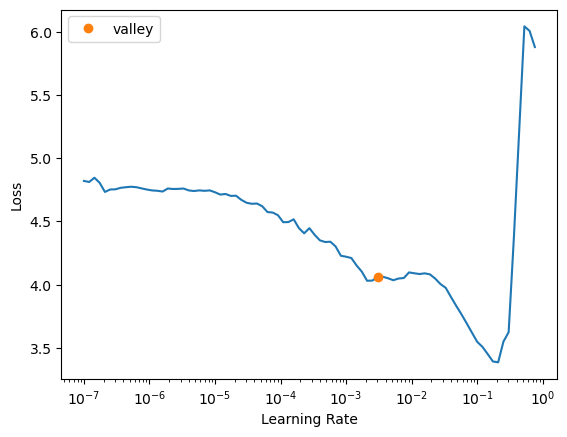

In [32]:
learn.lr_find()

In [41]:
learn.fine_tune(10, 1e-5)

epoch,train_loss,valid_loss,error_rate,f1_score,time
0,0.471078,0.664337,0.289855,0.710145,03:15


epoch,train_loss,valid_loss,error_rate,f1_score,time
0,0.450740,0.685804,0.289855,0.710145,03:15
1,0.430803,0.650024,0.246377,0.753623,03:12
2,0.405487,0.671982,0.275362,0.724638,03:10
3,0.391177,0.690602,0.304348,0.695652,03:10
4,0.402324,0.675621,0.275362,0.724638,03:08
5,0.383394,0.653294,0.260870,0.739130,03:10
6,0.385155,0.645805,0.246377,0.753623,03:09
7,0.400332,0.672988,0.260870,0.739130,03:09
8,0.386414,0.665438,0.260870,0.739130,03:13
9,0.396440,0.650527,0.231884,0.768116,03:13


In [34]:
learn.save('throwin_v2_256')
learn.export('throwin_v2_256.pkl')

In [19]:
dls = get_action_dataloaders(instances_path, bs=8, image_size=512, seq_len=8)
learn = Learner(dls, model, metrics=[error_rate, F1Score(average='micro')], splitter=rnnmodel_splitter).to_fp16()

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [20]:
learn.fine_tune(10, 1e-3)

epoch,train_loss,valid_loss,error_rate,f1_score,time
0,3.287969,4.040057,0.928571,0.071429,04:12


epoch,train_loss,valid_loss,error_rate,f1_score,time
0,1.840520,2.080463,0.585714,0.414286,04:19
1,1.578168,2.218048,0.485714,0.514286,04:00
2,1.245507,0.824867,0.271429,0.728571,04:11
3,0.895205,1.335568,0.414286,0.585714,03:59
4,0.731094,2.077296,0.271429,0.728571,03:46
5,0.616390,1.227647,0.300000,0.700000,03:49
6,0.519704,0.475264,0.185714,0.814286,03:45
7,0.415120,0.288269,0.142857,0.857143,03:44
8,0.315874,0.283020,0.128571,0.871429,03:44
9,0.295838,0.288723,0.128571,0.871429,03:44


In [21]:
learn.save('model_512')

Path('models/model_512.pth')

Best params so far:
- 8 frames
- Image size: 256
- Epochs trained: 10
- Batch Size: 16
- Error/F1: 8.5%/0.91
- filename: model_256_91.pth

In [31]:
learn.load('throwin_256_91')
learn.export('throwin_256.pkl')

In [35]:
learn.predict(data_path/'test'/'0b1495d3_0'/'0')

('False',
 TensorBase(0),
 TensorBase([9.7059e-01, 2.5304e-05, 2.9344e-04, 3.5647e-04, 3.6922e-04,
             3.0647e-04, 2.2897e-04, 2.5858e-04, 2.8692e-04, 2.9762e-04,
             2.7099e-04, 2.2953e-04, 2.6953e-04, 2.9073e-04, 2.7072e-04,
             3.1946e-04, 2.4232e-04, 2.7271e-04, 3.5188e-04, 2.6099e-04,
             3.4466e-04, 2.0217e-04, 3.9055e-04, 3.5944e-04, 4.2977e-04,
             3.5812e-04, 2.5883e-04, 3.2607e-04, 2.6226e-04, 2.9286e-04,
             2.7271e-04, 3.2536e-04, 2.3133e-04, 3.5197e-04, 3.0819e-04,
             2.9186e-04, 2.8385e-04, 3.1985e-04, 3.0334e-04, 3.9956e-04,
             2.8399e-04, 2.7877e-04, 3.1798e-04, 2.1902e-04, 2.3763e-04,
             2.6137e-04, 3.1046e-04, 3.1751e-04, 3.5102e-04, 2.7205e-04,
             2.7033e-04, 3.7239e-04, 3.0025e-04, 2.9718e-04, 3.1450e-04,
             2.9530e-04, 3.2417e-04, 2.8524e-04, 3.4348e-04, 2.2106e-04,
             3.9188e-04, 3.4264e-04, 3.6519e-04, 2.7539e-04, 4.4412e-04,
             2.7351e-04, 

In [49]:
labeller(neg_paths[0])

False

In [28]:
from timesformer_pytorch import TimeSformer

In [29]:
class MyTimeSformer(TimeSformer):
    def forward(self, x):
        x = torch.stack(x, dim=1)
        return super().forward(x)

In [30]:
timesformer = MyTimeSformer(
    dim = 256,
    image_size = 256,
    patch_size = 16,
    num_frames = 8,
    num_classes = 101,
    depth = 12,
    heads = 8,
    dim_head =  64,
    attn_dropout = 0.1,
    ff_dropout = 0.1
).cuda()

In [31]:
learn_tf = Learner(dls, timesformer, metrics=[error_rate, F1Score()]).to_fp16()

In [32]:
learn_tf.lr_find()

c:\ProgramData\Anaconda3\envs\fastai\lib\site-packages\timesformer_pytorch\timesformer_pytorch.py:28: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if amt is 0:
c:\ProgramData\Anaconda3\envs\fastai\lib\site-packages\timesformer_pytorch\timesformer_pytorch.py:28: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if amt is 0:
c:\ProgramData\Anaconda3\envs\fastai\lib\site-packages\timesformer_pytorch\timesformer_pytorch.py:28: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if amt is 0:
c:\ProgramData\Anaconda3\envs\fastai\lib\site-packages\timesformer_pytorch\timesformer_pytorch.py:28: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if amt is 0:
c:\ProgramData\Anaconda3\envs\fastai\lib\site-packages\timesformer_pytorch\timesformer_pytorch.py:28: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if amt is 0:


RuntimeError: CUDA out of memory. Tried to allocate 34.00 MiB (GPU 0; 8.00 GiB total capacity; 6.99 GiB already allocated; 0 bytes free; 7.27 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF